In [2]:
import os, sys
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
sys.path.append(os.getcwd())
import argparse, random
from tqdm import tqdm
import pandas as pd

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

from advertorch.attacks import GradientSignAttack, LinfBasicIterativeAttack, LinfPGDAttack, CarliniWagnerL2Attack
from advertorch.attacks.utils import multiple_mini_batch_attack, attack_whole_dataset
from advertorch.utils import to_one_hot

sys.path.append("..") 
import arguments, utils
from models.ensemble import Ensemble
from distillation import Linf_PGD
import freq_heatmap

/home/ustc/anaconda3/envs/en/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
parser = argparse.ArgumentParser(description='Evaluation of White-box Robustness of Ensembles with Advertorch', add_help=True)
arguments.model_args(parser)
arguments.data_args(parser)
arguments.wbox_eval_args(parser)
args = parser.parse_args(args=['--gpu', '0', '--model-file', '/data/zwl/zwl/DVERGE_code/checkpoints_zl/baseline_c100/seed_0/3_ResNet20/res_vanilla_cifa100_epoch_200.pth','--steps', '50', '--random-start', '5', '--save-to-csv'])

In [4]:
print(os.path.abspath('.'))

/data/zwl/zwl/DVERGE_code/eval


In [5]:
# get args
# args = get_args()

# set up gpus
os.environ["CUDA_VISIBLE_DEVICES"] = args.gpu
assert torch.cuda.is_available()

# load models
if 'gal' in args.model_file:
    leaky_relu = True
else:
    leaky_relu = False

print(args.model_file)

ensemble = utils.get_models(args, train=False, as_ensemble=False, model_file=args.model_file, leaky_relu=leaky_relu)

args.data_dir = '../data/'

# get data loaders
total_sample_num = 10000

if args.subset_num:
    random.seed(0)
    subset_idx = random.sample(range(total_sample_num), args.subset_num)
    testloader = utils.get_testloader(args, batch_size=500, shuffle=False, subset_idx=subset_idx)
else:
    testloader = utils.get_testloader(args, batch_size=500, shuffle=False)

/data/zwl/zwl/DVERGE_code/checkpoints_zl/baseline_c100/seed_0/3_ResNet20/res_vanilla_cifa100_epoch_200.pth
Files already downloaded and verified


In [6]:
def accuracy(y_pred, y_true):
    y_pred = torch.argmax(y_pred, dim=1)
    correct = (y_pred == y_true).float()
    acc = correct.sum() / len(correct)
    return acc

In [7]:
from freq_heatmap import _generate_perturbed_images, _get_fourier_basis, _get_sum_of_norms
heat_map = torch.zeros([32,32])
for idx, (x_np, y_np) in enumerate(testloader):
    height = 32
    width = 32
    clip_max = 1
    clip_min = 0
    perturb_norm = 1
    rand_flip = False
    neural_network =  ensemble[2].cpu()

    basis = _get_fourier_basis(height, width)

    y_pred = neural_network(x_np)
    cur_acc = accuracy(y_pred, y_np)

    x_np = x_np.permute([0,2,3,1])
    
    for i in range(height):
        for j in range(width):
            perturb_images = _generate_perturbed_images(x_np,
                                                        basis[i, j, Ellipsis],
                                                        perturb_norm, clip_min,
                                                        clip_max, rand_flip)
            perturb_images = perturb_images.permute([0,3,1,2])
            
            y_pred_perturb = neural_network(perturb_images)
            acc = accuracy(y_pred_perturb, y_np)
            err_rate = (cur_acc - acc) / cur_acc
            # Accumulate the evaluation criterion under perturbed inputs.
            heat_map[i, j] += err_rate
    break

In [13]:
torch.save(heat_map ,os.path.join(os.path.abspath('.') , 'err_c100.pt'))
print(torch.min(heat_map),torch.mean(heat_map),torch.var(heat_map))
print(heat_map)

tensor(-0.0161) tensor(0.5183) tensor(0.0717)
tensor([[0.9581, 0.9161, 0.9194,  ..., 0.9065, 0.9194, 0.9161],
        [0.9323, 0.9129, 0.9032,  ..., 0.9097, 0.9129, 0.9290],
        [0.8839, 0.8935, 0.9000,  ..., 0.9032, 0.9000, 0.9065],
        ...,
        [0.9065, 0.9000, 0.8968,  ..., 0.8581, 0.8645, 0.8871],
        [0.8839, 0.9065, 0.9000,  ..., 0.8839, 0.9000, 0.8935],
        [0.9323, 0.9290, 0.9129,  ..., 0.9097, 0.9032, 0.9129]])


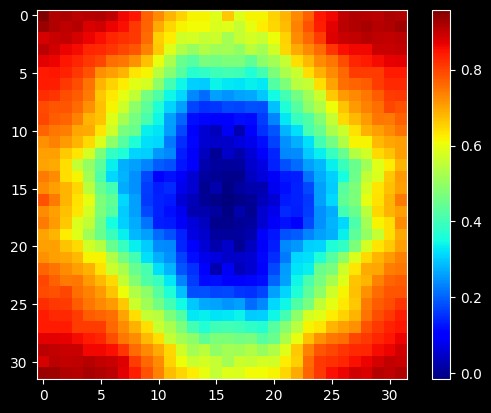

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# 绘制热力图,200个样本
heatmap = plt.imshow(heat_map, cmap='jet', interpolation='nearest')
plt.colorbar(heatmap)
plt.show()

In [10]:
heat_map[16,0] =  heat_map[16,0] - 0.1

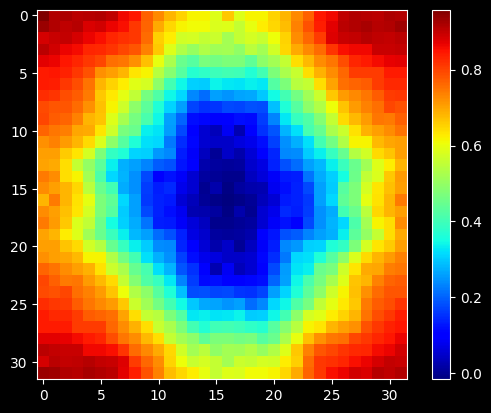

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# 绘制热力图,500个样本
heatmap = plt.imshow(heat_map, cmap='jet', interpolation='nearest')
plt.colorbar(heatmap)
plt.show()

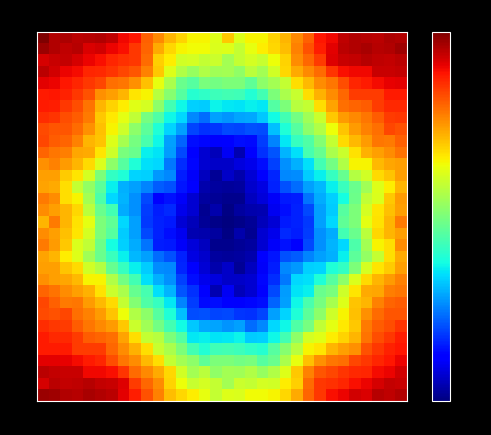

In [12]:
import matplotlib as mpl

mpl.rcParams['text.color'] = 'black'
heatmap = plt.imshow(heat_map, cmap='jet', interpolation='nearest')
plt.title('CIFAR10')
plt.tick_params(colors='black')
cbar = plt.colorbar(heatmap)
cbar.ax.tick_params(colors='black')
plt.savefig('heatmap.png', dpi=300, facecolor='white', transparent=False)